# Australian dataset: yearly analysis

In [1]:
%run preamble.py
ausautoBI8999 = pd.read_csv("../Data/ausautoBI8999.csv")

In [2]:
from datetime import datetime
aus = pd.concat([ausautoBI8999[["FinDate", "FinMth" ,"AggClaim"]], 
                 pd.DataFrame({'year':np.array([datetime.fromisoformat(ausautoBI8999["FinDate"].iloc[k]).year 
                                                for k in range(len(ausautoBI8999["FinDate"]))])})
                ], axis = 1)
print(aus[["FinDate", "FinMth", "AggClaim"]].head(5).to_latex(index=False))
print(aus[["AggClaim"]].describe().applymap("{:.2f}".format).to_latex())

\begin{tabular}{lrr}
\toprule
   FinDate &  FinMth &  AggClaim \\
\midrule
1993-10-01 &      52 &     87.75 \\
1994-02-01 &      56 &    353.62 \\
1994-02-01 &      56 &    688.83 \\
1994-05-01 &      59 &    172.80 \\
1994-09-01 &      63 &     43.29 \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
{} &    AggClaim \\
\midrule
count &    22036.00 \\
mean  &    38367.22 \\
std   &    90981.11 \\
min   &        9.96 \\
25\%   &     6296.97 \\
50\%   &    13853.87 \\
75\%   &    35123.42 \\
max   &  4485797.21 \\
\bottomrule
\end{tabular}



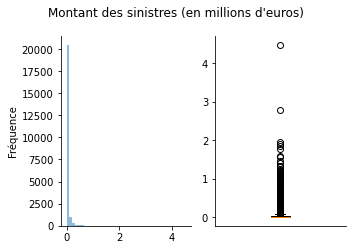

In [3]:
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout=True)
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(aus.AggClaim / 1e6, num_bins, alpha=0.5)
axs[1].boxplot(aus.AggClaim / 1e6)
axs[0].set_xlabel("")
axs[0].set_ylabel("Fréquence")
axs[1].set_ylabel("")
axs[1].set_xticks([])
plt.suptitle("Montant des sinistres (en millions d'euros)")
# plt.show()
sns.despine()
plt.savefig("../Figures/hist_box_aus.pdf")

# Yearly analysis
## Rolling quantiles

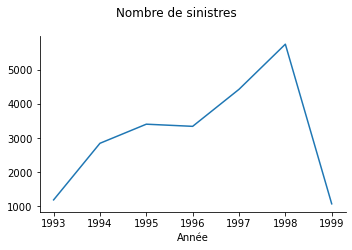

In [4]:
count_nb_claim = aus.groupby('year').count()['AggClaim'].reset_index()
fig, axs = plt.subplots(1,1, figsize=(5, 3.5), tight_layout = True)


axs.plot(count_nb_claim['year'], count_nb_claim['AggClaim'])
axs.set_xlabel('Année')


sns.despine()
plt.suptitle("Nombre de sinistres")
plt.savefig("../Figures/yearly_n_claim_aus.pdf")

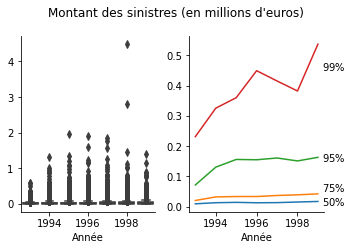

In [5]:
#Rolling mean, median 95 and 99% quantile for years and month
Quantities = ['q50', 'q75', 'q95', 'q99']
Quantity_labels  = ["Quantile à $50\%$",
                   "Quantile à $75\%$",
                   "Quantile à $95\%$",
                   "Quantile à $99\%$"
                  ]
aus['scaled_aggclaims'] = aus['AggClaim'] / 1e6 
yearly_df = pd.DataFrame({'year':np.unique(aus['year']),
                          'q50':aus[['year', "scaled_aggclaims"]].groupby('year').quantile(0.5).values.flatten(), 
                          'q75': aus[['year', "scaled_aggclaims"]].groupby('year').quantile(0.75).values.flatten(), 
                          'q95': aus[['year', "scaled_aggclaims"]].groupby('year').quantile(0.95).values.flatten(), 
                          'q99' : aus[['year', "scaled_aggclaims"]].groupby('year').quantile(0.99).values.flatten()}
                        )

fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
sns.boxplot(x = "year" , y = "scaled_aggclaims", data = aus, ax = axs[0])
axs[0].tick_params( axis = 'x')
axs[0].set_ylabel('')
axs[0].set_xlabel('Année')
axs[0].set_xticks([1, 3, 5])
for k, quantity in enumerate(Quantities):
    axs[1].plot(yearly_df['year'], yearly_df[quantity], label = Quantity_labels[k])
axs[1].set_xlabel('Année')


axs[1].text(1999.2, 0.005,'$50\%$', fontsize = 10)
axs[1].text(1999.2, 0.05,'$75\%$', fontsize = 10)
axs[1].text(1999.2, 0.15,'$95\%$', fontsize = 10)
axs[1].text(1999.2, 0.45,'$99\%$', fontsize = 10)
sns.despine()
plt.suptitle("Montant des sinistres (en millions d'euros)")
plt.savefig("../Figures/yearly_rolling_box_quantile_aus.pdf")


## SMC inference of the composite models

In [6]:
# Prior settings
years = np.unique(aus['year'])
loss_models = ['lnorm-par', 'wei-par', "gam-par"]
traces_yearly, summaries_yearly = [], []
for year in years:
    print("Fitting year "+str(year))
    selec = aus['year'].values == year
    X = aus['scaled_aggclaims'].iloc[selec].values
    model_prior, a, b =  "gamma", 0.1 * np.ones(3), 0.1 * np.ones(3)
    # SMC settings
    popSize, verbose, smc_method, paralell, nproc = 1000, True, "likelihood_anealing", True, 20
    start_time = time()
    traces_year, summary_year = fit_composite_models_smc(X,loss_models,
                                                         model_prior, a, b, popSize, verbose, smc_method, paralell, nproc)
    print("Time: "+str(time() -  start_time))
    summary_year['year'] = year
    traces_yearly.append(traces_year)
    summaries_yearly.append(summary_year)

Fitting year 1993
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 91.07846975326538
Fitting year 1994
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 288.2857210636139
Fitting year 1995
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 351.8280026912689
Fitting year 1996
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 330.84231996536255
Fitting year 1997
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 352.60035824775696
Fitting year 1998
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 526.8282766342163
Fitting year 1999
Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 147.11310505867004


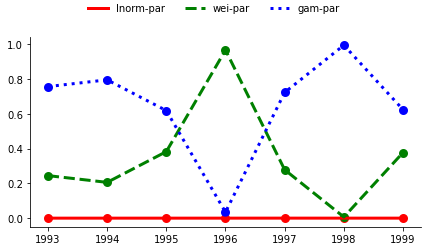

In [7]:
summaries_df = pd.concat(summaries_yearly)
loss_models = ['lnorm-par', 'wei-par', "gam-par"]
linestyles = ['solid', 'dashed', 'dotted']
colors = ['red', "green", "blue"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df['loss_model'].values == loss_model
    plt.plot(summaries_df['year'].iloc[selec].values, summaries_df['model_evidence'].iloc[selec].values,
             label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df['year'].iloc[selec].values, summaries_df['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3)
    plt.xticks(summaries_df['year'].iloc[selec].values)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/yearly_model_evidence_aus_data_1.pdf")

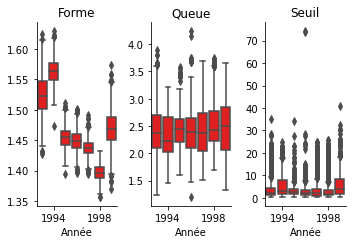

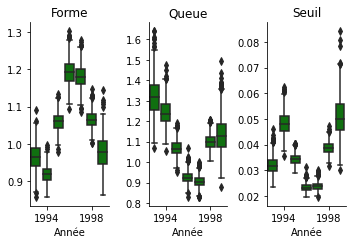

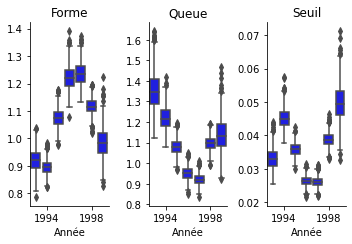

In [8]:
for i, loss_model in enumerate(loss_models):
    list_df = []
    for k, year in enumerate(years):
        df_temp = traces_yearly[k][loss_model]
        df_temp['year'] = year
        list_df.append(df_temp)
    res = pd.concat(list_df)

    parms_names = ["shape", "tail", "thres"]
    title_labs = ["Forme", "Queue", "Seuil"]
    fig, axs = plt.subplots(1,3, figsize=(5, 3.5), tight_layout = True)

    for k, parm_name in enumerate(parms_names):
        sns.boxplot(x = "year" , y = parm_name, data = res, ax = axs[k], color = colors[i])
    #     sns.stripplot(x = "year" , y = parm_name, data = res, ax = axs[k], color = "black", alpha = 0.3)
        axs[k].tick_params( axis = 'x')
        axs[k].set_ylabel('')
        axs[k].set_xlabel('Année')
        axs[k].set_xticks([1, 5])
        axs[k].set_title(title_labs[k])
    sns.despine()
    plt.savefig("../Figures/yearly_post_dist_"+str(loss_model)+"_aus_data.pdf")

In [9]:
summaries_df['index'] = np.arange(0, len(years) * 3, 1)
VaRs = pd.DataFrame(np.array([[quantile_compo(0.95, summaries_df['loss_model'].iloc[k], summaries_df[parms_names].iloc[k].values), 
     quantile_compo(0.99, summaries_df['loss_model'].iloc[k], summaries_df[parms_names].iloc[k].values )] 
                              for k in range(len(summaries_df))]), 
                        index = np.arange(0, len(years) * 3, 1))
VaRs.columns = ['q95_compo', 'q99_compo']
quantile_df = pd.merge(summaries_df, VaRs.reset_index()).set_index('index')
quantile_df
quantile_df['q95_weighted'] = quantile_df['q95_compo'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99_compo'] * quantile_df['model_evidence']
# quantile_df
q_ens = quantile_df[['year', 'q95_weighted', 'q99_weighted']].groupby('year').sum().reset_index().rename(columns = {"q95_weighted":"q95",
                                                                                                                    "q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(yearly_df[['year', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))
q_compo = quantile_df[['year',"loss_model", "q95_compo","q99_compo"] ].rename(columns = {"q95_compo":"q95","q99_compo":"q99"})
q_df_1 = pd.concat([q_compo, q_ens, q_emp])


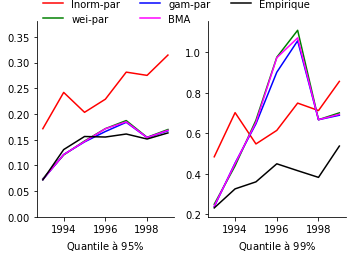

In [10]:
loss_models, colors, model_labs = ["lnorm-par", "wei-par", "gam-par", "ensemble", "empirical"] ,\
["red", "green", "blue","magenta", "black"] , ["lnorm-par", "wei-par", "gam-par","BMA", "Empirique"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df_1['loss_model'].values == loss_model
    axs[0].plot(q_df_1['year'].iloc[selec], q_df_1['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("Quantile à $95\%$")
    axs[1].plot(q_df_1['year'].iloc[selec], q_df_1['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("Quantile à $99\%$")

axs[0].set_ylim([0, 0.38])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.43, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/yearly_q_compo_aus_data_1.pdf")


## SMC inference of the Weibull and gamma composite models

In [11]:
selec = np.array(summaries_df.loss_model == "wei-par") | np.array(summaries_df.loss_model == "gam-par")
df = summaries_df.iloc[selec]
log_marg_df = df[['year', 'log_marg']].groupby('year').max('log_marg').rename(columns = {'log_marg':'max_log_marg'})
df = pd.merge(df, log_marg_df.reset_index(), on = 'year')
df['marg'] =  np.exp(df.log_marg - df.max_log_marg)
marg_df = df[['year', 'marg']].groupby('year').sum('marg').reset_index().rename(columns = {'marg' : "sum_marg"})
df = pd.merge(df, marg_df, on = 'year')
df['model_evidence'] = df.marg / df.sum_marg
summaries_df_2 = df[['year', 'loss_model','log_marg', 'DIC', "WAIC", "model_evidence"] + parms_names ]
summaries_df_2

,year,loss_model,log_marg,DIC,WAIC,model_evidence,shape,tail,thres
0,1993,wei-par,3558.075333,-7152.024019,-7138.974868,0.244299,0.964056,1.320986,0.031939
1,1993,gam-par,3559.204586,-7153.630756,-7140.700044,0.755701,0.920019,1.352801,0.032977
2,1994,wei-par,7314.309153,-14668.419229,-14654.911648,0.205538,0.918157,1.242218,0.048499
3,1994,gam-par,7315.661190,-14669.769058,-14657.277346,0.794462,0.895203,1.219572,0.045079
4,1995,wei-par,8423.633398,-16887.200224,-16874.574786,0.382179,1.060087,1.068238,0.034464
5,1995,gam-par,8424.113709,-16887.340494,-16874.629431,0.617821,1.074665,1.079347,0.035891
6,1996,wei-par,8324.802590,-16687.449645,-16674.187513,0.965628,1.192246,0.925438,0.023224
7,1996,gam-par,8321.467049,-16683.300975,-16670.050918,0.034372,1.221176,0.950467,0.026348
8,1997,wei-par,10779.725451,-21598.271512,-21585.183553,0.277820,1.181019,0.904500,0.023844
9,1997,gam-par,10780.680754,-21602.661692,-21589.588659,0.722180,1.235759,0.919754,0.026178


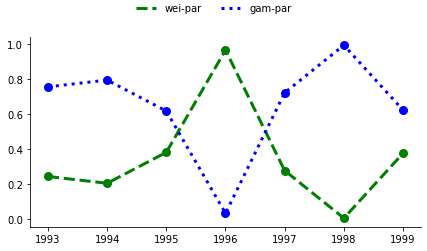

In [12]:
loss_models = ['wei-par', "gam-par"]
linestyles = [ 'dashed', 'dotted']
colors = ["green", "blue"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df_2['loss_model'].values == loss_model
    plt.plot(summaries_df_2['year'].iloc[selec].values, summaries_df_2['model_evidence'].iloc[selec].values,
             label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df_2['year'].iloc[selec].values, summaries_df_2['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3)
    plt.xticks(summaries_df_2['year'].iloc[selec].values)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], ncol = 2, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/yearly_model_evidence_aus_data_2.pdf")

In [13]:
loss_models = ['wei-par', "gam-par"]
# summaries_df_2['index'] = np.arange(0, len(years) * len(loss_models), 1)
VaRs = pd.DataFrame(np.array([[quantile_compo(0.95, summaries_df_2['loss_model'].iloc[k], summaries_df_2[parms_names].iloc[k].values), 
     quantile_compo(0.99, summaries_df_2['loss_model'].iloc[k], summaries_df_2[parms_names].iloc[k].values )] 
                              for k in range(len(summaries_df_2))]), 
                        index = np.arange(0, len(years) * len(loss_models), 1))
VaRs.columns = ['q95_compo', 'q99_compo']
quantile_df = pd.merge(summaries_df_2.reset_index(), VaRs.reset_index()).set_index('index')
quantile_df
quantile_df['q95_weighted'] = quantile_df['q95_compo'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99_compo'] * quantile_df['model_evidence']
# quantile_df
q_ens = quantile_df[['year', 'q95_weighted', 'q99_weighted']].groupby('year').sum().reset_index().rename(columns = {"q95_weighted":"q95",
                                                                                                                    "q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(yearly_df[['year', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))
q_compo = quantile_df[['year',"loss_model", "q95_compo","q99_compo"] ].rename(columns = {"q95_compo":"q95","q99_compo":"q99"})
q_df_2 = pd.concat([q_compo, q_ens, q_emp])
q_df_2

,year,loss_model,q95,q99
0,1993,wei-par,0.073864,0.249783
1,1993,gam-par,0.072290,0.237554
2,1994,wei-par,0.120277,0.439405
3,1994,gam-par,0.121174,0.453458
4,1995,wei-par,0.147380,0.664907
5,1995,gam-par,0.145658,0.647024
6,1996,wei-par,0.171453,0.975955
7,1996,gam-par,0.165883,0.901981
8,1997,wei-par,0.187166,1.109169
9,1997,gam-par,0.183741,1.057207


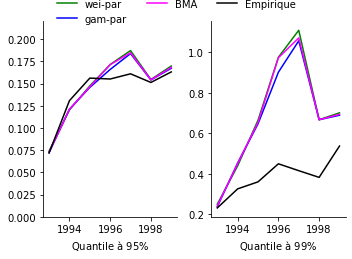

In [14]:
loss_models, colors, model_labs = ["wei-par", "gam-par", "ensemble", "empirical"] ,\
["green", "blue","magenta", "black"] , ["wei-par", "gam-par","BMA", "Empirique"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df_2['loss_model'].values == loss_model
    axs[0].plot(q_df_2['year'].iloc[selec], q_df_2['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("Quantile à $95\%$")
    axs[1].plot(q_df_2['year'].iloc[selec], q_df_2['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("Quantile à $99\%$")

axs[0].set_ylim([0, 0.22])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.43, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/yearly_q_compo_aus_data_2.pdf")

## SMC inference of lognormal model to be compared with the weibull and gamma models

In [15]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

In [ ]:
traces_lnorm = []
for year in years:
    print("Fitting year "+str(year))
    selec = aus['year'].values == year
    X = aus['scaled_aggclaims'].iloc[selec].values
    with pm.Model() as model_sev:
        μ = pm.Normal("mu",mu=0, sigma=10)
        σ = pm.Gamma("sig",alpha = 0.1, beta = 0.1)
        U = pm.Lognormal("U", mu=μ, sigma=σ, observed=X)
        %time trace = pm.sample_smc(popSize, random_seed=1, chains = 1,  parallel=True, cores=2)
        traces_lnorm.append(trace)

Fitting year 1993
CPU times: user 11.2 s, sys: 885 ms, total: 12.1 s
Wall time: 7.17 s
Fitting year 1994
CPU times: user 13.7 s, sys: 682 ms, total: 14.4 s
Wall time: 5.65 s
Fitting year 1995
CPU times: user 14.4 s, sys: 686 ms, total: 15 s
Wall time: 5.82 s
Fitting year 1996
CPU times: user 14.3 s, sys: 673 ms, total: 15 s
Wall time: 6.24 s
Fitting year 1997
CPU times: user 14.7 s, sys: 697 ms, total: 15.4 s
Wall time: 6.58 s
Fitting year 1998
CPU times: user 16.2 s, sys: 668 ms, total: 16.8 s
Wall time: 7.74 s
Fitting year 1999


In [ ]:
res = pd.concat([
    summaries_df_2.reset_index()[['loss_model', 'year', 'log_marg']],
    pd.DataFrame({
        'loss_model': np.repeat("lnorm", len(years)),
        'year': years,
        'log_marg':np.array([traces_lnorm[k].report.log_marginal_likelihood for k in range(len(traces_lnorm))]).flatten()
        })
])
res_1 = pd.merge(res, res.groupby('year').max('log_marg').reset_index().rename(columns = {"log_marg":"max_log_marg"}))
res_1['marg'] = np.exp(res_1['log_marg']- res_1['max_log_marg'])
res_2  = pd.merge(res_1, res_1.groupby('year').sum('marg')['marg'].reset_index().rename(columns = {"marg":"sum_marg"}))
res_2['model_evidence'] = res_2['marg'] / res_2['sum_marg']
summaries_df_3 = res_2[['loss_model', 'year', 'log_marg', "model_evidence"]]
summaries_df_3


In [ ]:
loss_models = ["lnorm", "wei-par", "gam-par"]
linestyles = ['solid', 'dashed', 'dotted']
colors = ['red', "green", "blue"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df_3['loss_model'].values == loss_model
    plt.plot(summaries_df_3['year'].iloc[selec].values, summaries_df_3['model_evidence'].iloc[selec].values,
             label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df_3['year'].iloc[selec].values, summaries_df_3['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3)
    plt.xticks(summaries_df_3['year'].iloc[selec].values)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], ncol = 2, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/yearly_model_evidence_aus_data_3.pdf")

In [ ]:
list_df = []
for i in range(len(traces_lnorm)):
    res = pd.DataFrame({
        "mu":traces_lnorm[i]["mu"],
        "sig": traces_lnorm[i]["sig"]})
    res["year"] = years[i]
    list_df.append(res)
traces_lnorm_df = pd.concat(list_df)

parms_names = ["mu", "sig"]
title_labs = ["$\mu$", "$\sigma$"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)

for k, parm_name in enumerate(parms_names):
    sns.boxplot(x = "year" , y = parm_name, data = traces_lnorm_df, ax = axs[k], color = "red")
    axs[k].tick_params( axis = 'x')
    axs[k].set_ylabel('')
    axs[k].set_xlabel('Année')
    axs[k].set_xticks([1, 5])
    axs[k].set_title(title_labs[k])
sns.despine()
plt.savefig("../Figures/yearly_post_dist_lnorm_aus_data.pdf")

In [ ]:
list_q = []
map_lnorm = traces_lnorm_df.groupby('year').mean().reset_index()
for k in range(len(years)):
    mu, sig = map_lnorm[["mu", "sig"]].iloc[k]
    res = st.lognorm(s = sig , scale = np.exp(mu)).ppf([0.95, 0.99])
    list_q.append(res)
q_lnorm = pd.DataFrame(np.vstack(list_q), columns = ["q95", "q99"])
q_lnorm["year"] = years
q_lnorm["loss_model"] = np.repeat("lnorm", len(years))
selec = np.array(q_df_2['loss_model'] == "wei-par") | np.array(q_df_2['loss_model'] == "gam-par") 
q_compo = q_df_2.iloc[selec]
quantile_df = pd.merge(summaries_df_3[["loss_model", "year", "model_evidence"]], pd.concat([q_lnorm, q_compo]), 
         on = ["loss_model", "year"] )
quantile_df['q95_weighted'] = quantile_df['q95'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99'] * quantile_df['model_evidence']
q_ens = quantile_df[['year', 'q95_weighted', 'q99_weighted']].groupby('year').sum().reset_index().\
rename(columns = {"q95_weighted":"q95","q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(yearly_df[['year', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))

q_df_3 = pd.concat([q_compo, q_lnorm, q_ens, q_emp])
q_df_3

In [ ]:
loss_models, colors, model_labs = ["lnorm", "wei-par", "gam-par", "ensemble", "empirical"] ,\
["red", "green", "blue","magenta", "black"] , ["lnorm", "wei-par", "gam-par","BMA", "Empirique"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df_3['loss_model'].values == loss_model
    axs[0].plot(q_df_3['year'].iloc[selec], q_df_3['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("Quantile à $95\%$")
    axs[1].plot(q_df_3['year'].iloc[selec], q_df_3['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("Quantile à $99\%$")

axs[0].set_ylim([0, 0.22])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.43, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/yearly_q_compo_aus_data_3.pdf")